# More Complex Models with the Functional API

Although the Sequential API in Keras is quite straightforward and Sequential models are quite common, it is sometime useful to build networks with more complex topologies, or multiple inputs or outputs. The Keras Functional API provides a more flexible way to define models that makes this possible. It is particularly useful for models with non-linear topology, shared layers, or multiple inputs/outputs. 

In this lecture, we'll delve into the Functional API with a focus on building a ["Wide & Deep" network](https://ai.google/research/pubs/pub45413), a model architecture that can manage both deep and wide feature learning effectively.

#### When to Use the Functional API

- **Model Complexity:** The Functional API is ideal when dealing with complex model architectures, such as those requiring multiple input and output layers, shared layers, or residual connections.
- **Flexibility:** It allows for more customization and control over your model architecture. Unlike the Sequential API, where layers are stacked linearly, the Functional API enables you to define more complex and non-linear relationships.
- **Research and Experimentation:** If you're experimenting with novel architectures or conducting research, the Functional API allows for more experimental flexibility.

## Designing a Wide & Deep Network for More Complex Data

The "Wide & Deep" learning model, conceptualized by Google, is designed to effectively harness both linear and non-linear feature representations. Understanding why and how this model works involves delving into the strengths of its two components: the "wide" part for linear aspects and the "deep" part for complex relationships.

<div style="text-align:center">

![wide and deep nn](assets/wide_and_deep.png)

</div>

#### The "Wide" Component

- **Linear Relationships:**
  - The wide part of the model is designed to learn linear relationships. This means it's good at memorizing or managing sparse data and feature interactions.
  - In practice, this often translates to a form of logistic regression or linear regression, depending on the task.

- **Feature Interactions:**
  - The wide component can effectively capture simple rules and interactions between features. For instance, if certain feature combinations are particularly predictive of the target variable, the wide component can learn this directly.

- **Advantage in Memorization:**
  - The wide part excels in memorization, which is beneficial for learning from sparse data where certain feature combinations may be very predictive but don't occur frequently enough for a deep model to learn and generalize. Categorical features, especially those with a large number of possible values, often work well with the wide part. 

#### The "Deep" Component

- **Complex Relationships:**
  - The deep component, typically a deep neural network, is adept at learning complex, non-linear relationships and feature hierarchies.
  - These networks automatically learn to represent data in a hierarchical fashion (low-level features in early layers, more abstract features in deeper layers).

- **Generalization:**
  - Deep networks are particularly good at generalizing to new scenarios. They can infer unseen relationships based on the hierarchies they've learned, making them powerful for tasks involving unstructured data like images and text.

- **Feature Learning:**
  - Unlike the wide part, deep networks don't require explicit feature engineering. They can automatically learn useful representations from raw data, making them highly versatile and adaptable. Numerical features, particularly those that require complex transformations to relate to the output, are suitable for the deep part.
  

The Wide & Deep model combines the strengths of memorization and generalization. Use the wide part for features where the relationship with the output is expected to be linear or rule-based, and the deep part for more abstract patterns and relationships. For example, in a recommendation system, the wide part can effectively capture specific user-item interactions (like a particular user's preference for a specific genre), while the deep part can learn user preferences and item characteristics from user and item metadata.

When designing a Wide & Deep model, balance is key. Overemphasizing the wide part might lead to overfitting on specific feature combinations, while focusing too much on the deep part might result in missing out on simple, predictive rules in the data. The optimal balance often depends on the specific nature of the dataset and the problem.

## Implementing a Wide & Deep Network

We'll develop a Wide & Deep Network to tackle the [California Housing dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description). The dataset includes a mix of features, some of which have a clear linear relationship with the target variable, while others may have more complex, non-linear relationships.  For example, features like 'median income' might have a more straightforward, linear relationship with housing prices. In contrast, features like 'latitude' and 'longitude' could have a non-linear and more complex interaction with the price.

Our goal here is to predict the median house price for each "block group."  

#### Retrieving the data


In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

2024-04-04 14:06:28.103449: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 14:06:28.451091: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 14:06:28.679600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 14:06:29.838729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)
# Reserve an item for prediction
X_new = X_test[:3]

In [3]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [4]:
import numpy as np
# Note that outputs are in $100,000
print(f"Min {np.min(y_train_full)} - Max {np.max(y_train_full)}")


Min 0.14999 - Max 5.00001




#### Setting up the model



In [5]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Normalization layer to standardize the inputs,, , and one more Dense layer with a single neuron for the output layer, without any activation function
normalization_layer = tf.keras.layers.Normalization()

# two Dense layers with 30 neurons each, using the ReLU activation function
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")

#Concatenate layer - In a Wide & Deep network, you have two paths: the wide path (simple linear relationships) 
#and the deep path (complex non-linear relationships). The concatenate layer is used to merge these two paths. 
#It takes outputs from both the wide and deep components and concatenates them along a specified axis (by default, the last axis).
concat_layer = tf.keras.layers.Concatenate()

#Dense layer with a single neuron for the output layer, without any activation function.  This is the median housing price.
output_layer = tf.keras.layers.Dense(1)

# The Input object (the variable name input_ is used to avoid overshadowing Python’s built-in input() function). 
# This is a specification of the kind of input the model 
# will get, including its shape and optionally its dtype, which defaults to 32-bit floats. 
# A model may actually have multiple inputs, as you will see shortly.
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])


#Normalization layer just like a function, passing it the Input object. This is why this is called the functional API. 
# Note that we are just telling Keras how it should connect the layers together; no actual data is being processed yet, 
# as the Input object is just a data specification. In other words, it’s a symbolic input. The output of this call is 
# also symbolic: normalized doesn’t store any actual data, it’s just used to construct the model.
normalized = normalization_layer(input_)

# In the same way, we then pass normalized to hidden_layer1, which outputs hidden1, 
# and we pass hidden1 to hidden_layer2, which outputs hidden2.
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)

#So far we’ve connected the layers sequentially, but then we use the concat_layer to 
# concatenate the input and the second hidden layer’s output. Again, no actual data is 
# concatenated yet: it’s all symbolic, to build the model.
concat = concat_layer([normalized, hidden2])

# Then we pass concat to the output_layer, which gives us the final output.
output = output_layer(concat)

# Finally create the model, specifying inputs and outputs
model = tf.keras.Model(inputs=[input_], outputs=[output])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

Once again, we compile and train the model, just like before...

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

# This is necessary in order to make sure the normalization layer correctly calculate things like the mean and 
# standard deviation necessary
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - RootMeanSquaredError: 1.4413 - loss: 2.1591 - val_RootMeanSquaredError: 1.0328 - val_loss: 1.0661
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.7083 - loss: 0.5030 - val_RootMeanSquaredError: 0.6178 - val_loss: 0.3816
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6452 - loss: 0.4167 - val_RootMeanSquaredError: 0.6163 - val_loss: 0.3798
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6260 - loss: 0.3921 - val_RootMeanSquaredError: 0.5893 - val_loss: 0.3471
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6139 - loss: 0.3771 - val_RootMeanSquaredError: 0.5855 - val_loss: 0.3428
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6048 - loss: 0.3660 - val_RootMeanSquaredError: 0.5835 - val_loss: 0.3404
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.5976 - los

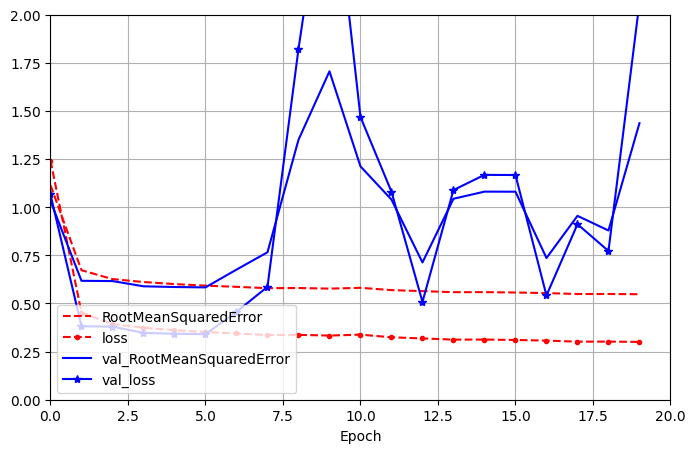

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 2], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

Yikes!  Note that an RMS error of 1 (roughly our mean validation error) is $100,000, which isn't great.

There are a few things we might try.  First, we might consider splitting our features, so that the "wide" and "deep" part of the network focus on different subsets of features.  For example, we might send the first five features through the wide path (based on the assumption that these should have a linear relationship with price) and the last six features through the deep path (assuming a more complex relationship here). Note that this is how we can use our domain knowledge to construct a network!

The envisioned network looks something like:

<div style="text-align:center">

![Wide and deep 2](assets/wide_and_deep2.png)

</div>


In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

input_wide = tf.keras.layers.Input(shape=[5]) # features 0 to 4 
input_deep = tf.keras.layers.Input(shape=[6]) # features 2 to 7 
norm_layer_wide = tf.keras.layers.Normalization() 
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)

# Note, the following is just a shorthand where we construct and then attach the network all in one go
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

Now we compile as usual, but we need to pass a pair of matrices in order to align with the expected input, and similarly with the validation and test data.

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

# Note the offsets are used here to split up the features according to our input layer
X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:] 
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:] 
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:] 
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]


norm_layer_wide.adapt(X_train_wide) 
norm_layer_deep.adapt(X_train_deep)

history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20, validation_data=((X_valid_wide, X_valid_deep), y_valid)) 
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 1.5706 - loss: 2.5748 - val_RootMeanSquaredError: 1.1185 - val_loss: 1.2506
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.7778 - loss: 0.6060 - val_RootMeanSquaredError: 0.6697 - val_loss: 0.4484
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6881 - loss: 0.4739 - val_RootMeanSquaredError: 0.6474 - val_loss: 0.4190
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6620 - loss: 0.4385 - val_RootMeanSquaredError: 0.7776 - val_loss: 0.6044
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6468 - loss: 0.4185 - val_RootMeanSquaredError: 0.7317 - val_loss: 0.5352
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6361 - loss: 0.4048 - val_RootMeanSquaredError: 1.2917 - val_loss: 1.6676
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6294 - los

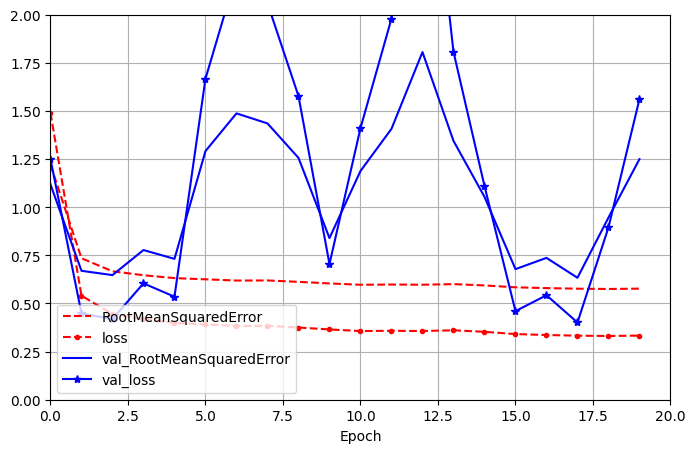

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 2], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

Yikes! Another thing we can try here is to give the hidden layers an explicit training signal in order to force them to learn something directly about the data.  This is a type of regularization, because it helps to constrain the hidden layers so that they are not simply "memorizing" the data.  Our new architecture would look something like:

<div style="text-align: center">

![Wide and deep 3](assets/wide_and_deep3.png)

</div>

Our auxiliary output requires is own loss function, but these two losses are combined during training.  Keras allows us to specify a weighting that will allow us to control the relative importance of these two losses.

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

Now we compile model and specify the different loss functions.

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

Now, training, being sure to specify the output labels for both output layers.

In [14]:
# Remember to adapt the normalization layers!!!
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - dense_2_RootMeanSquaredError: 1.5275 - dense_3_RootMeanSquaredError: 1.8463 - loss: 2.5236 - val_dense_2_RootMeanSquaredError: 1.6084 - val_dense_3_RootMeanSquaredError: 3.4516 - val_loss: 3.5180
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.7588 - dense_3_RootMeanSquaredError: 0.9685 - loss: 0.6125 - val_dense_2_RootMeanSquaredError: 1.0163 - val_dense_3_RootMeanSquaredError: 2.0664 - val_loss: 1.3560
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.6792 - dense_3_RootMeanSquaredError: 0.8207 - loss: 0.4828 - val_dense_2_RootMeanSquaredError: 0.6912 - val_dense_3_RootMeanSquaredError: 1.6525 - val_loss: 0.7028
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.6529 - dense_3_RootMeanSquaredError: 0.7780 - loss: 0.4444 - val_dense_2_RootMeanSquaredError: 0.6192 - val_dense_3_RootMeanSquaredError: 1.3087 - val_loss: 0.5162


In [16]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
print(f"""
Weighed Sum of Losses: {weighted_sum_of_losses}
Main Loss: {main_loss}
Aux Loss: {aux_loss}
Main RMSE: {main_rmse}
Aux RMSE: {aux_rmse}
      """)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - dense_2_RootMeanSquaredError: 0.5702 - dense_3_RootMeanSquaredError: 0.6263 - loss: 0.3319


ValueError: not enough values to unpack (expected 5, got 3)

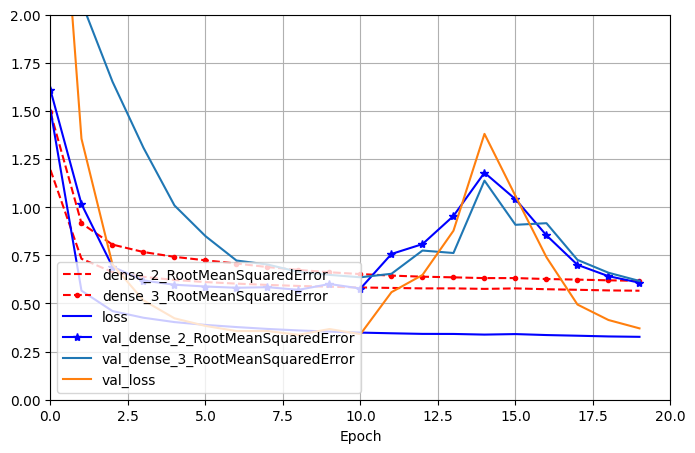

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 2], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

Note that this appears to have substantially improved things for the validation set, indicating that we indeed seem to be generalizing our data quite a bit better!

## Additional Software Features

Keras provides several additional software features that can be used to make the process of working with networks more useful.

#### The Subclassing API

The Subclassing API allows you to define custom models by subclassing the `tf.keras.Model` class. In this approach, you create a new class that inherits from `tf.keras.Model` and defines your own forward pass for the model. This method provides the greatest flexibility in defining models, as you can add loops, conditional branches, and even custom layers directly within your model.

#### Why Use the Subclassing API?

1. **Custom Behavior:**
   - If you need a model that does not fit the standard sequential or functional paradigms, subclassing enables you to implement custom behavior in the forward pass.

2. **Research and Experimentation:**
   - For researchers experimenting with new ideas, subclassing offers a way to express complex models or layers in an intuitive manner.

3. **Dynamic Models:**
   - Subclassing is particularly suited for dynamic models, where the architecture can change based on the input data, something that's harder to achieve with the Sequential and Functional APIs.

#### How to Implement a Model using Subclassing?

1. **Define a Model Class:**
   - Create a new class that inherits from `tf.keras.Model`.
   - Define the layers in the `__init__` method.
   - Implement the model's forward pass in the `call` method.

2. **Instantiate and Use the Model:**
   - Like other Keras models, you compile and train it using `.compile()` and `.fit()` methods.
   - It can be used for prediction with `.predict()`.

#### Key Points

- **Debugging:** Subclassing can make debugging easier since it works just like regular Python code.
- **Complexity:** It's slightly more complex and error-prone than using Sequential or Functional APIs due to the lack of model validation before training.
- **Serialization:** Subclassed models have limitations in terms of saving and loading. The structure of the model is not explicitly defined, so when saving the model, Keras saves the model's weights only.


In [18]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

Now, to instantiate and train:

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError","RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - RootMeanSquaredError: 1.5458 - RootMeanSquaredError_1: 1.8383 - loss: 2.5761 - val_RootMeanSquaredError: 0.7646 - val_RootMeanSquaredError_1: 1.6833 - val_loss: 0.8092
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.7345 - RootMeanSquaredError_1: 1.0185 - loss: 0.5902 - val_RootMeanSquaredError: 0.6503 - val_RootMeanSquaredError_1: 1.1410 - val_loss: 0.5107
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6773 - RootMeanSquaredError_1: 0.8782 - loss: 0.4903 - val_RootMeanSquaredError: 0.7339 - val_RootMeanSquaredError_1: 0.8369 - val_loss: 0.5546
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6580 - RootMeanSquaredError_1: 0.8112 - loss: 0.4557 - val_RootMeanSquaredError: 0.6260 - val_RootMeanSquaredError_1: 0.7916 - val_loss: 0.4152
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6439 - RootMeanSquaredError_1: 0.7

ValueError: not enough values to unpack (expected 5, got 3)

## Saving and restoring models

Models can be easily saved off for future use with:

In [ ]:
model.save("my_keras_model", save_format="tf")

All aspects of the model are saved this way, including weights and any hyperparameters.  Loading the model can be easily accomplished with:

In [ ]:
model = tf.keras.models.load_model("my_keras_model")

You can also save and load just the weights for a network, which is faster uses less disk space then storing the entire model.  This is useful when saving "checkpoints" during the model training process.  Checkpoints provide a restore point if something goes awry during the training process.  To accomplish this, we use callbacks, described below. 

### Using Callbacks

Sometimes it is useful to interrupt the training process to inspect aspects of the network. The `fit()` methods accepts a set of functions (referred to as callbacks) which can be run during the training process.  There are three places when you can run callback functions:
- Before and after training
- Before and after each epoch
- Before and after each batch

Keras offers a number of [pre-built callbacks](https://keras.io/api/callbacks/) and you [can write your own](https://keras.io/guides/writing_your_own_callbacks/) if you want.

#### Examples

**Model Checkpoints**

The ModelCheckpoint callback allows you to save checkpoints at regular intervals during training.  This can be useful both for inspection, and as a backup mechanism in case something goes wrong during training. This is also a nice way to avoid overtraining with too many epochs, since it is easy to roll back to a previous training state.

~~~python
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints", save_weights_only=True)
history = model.fit([...], callbacks=[checkpoint_cb])
~~~

**Early Stopping**

The `EarlyStopping` callback allows you to interrupt training when no progress is made on the validation step for a number of epochs.  Setting `restore_best_weights=True` will roll back to the best model at the end of training.

~~~python
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
history = model.fit([...], callbacks=[checkpoint_cb, early_stopping_cb])
~~~

### Using Tensorboard

Tensorflow provides a UI called Tensorboard for inspecting the performance of training.  To use Tensorboard, we need to log data in a special format using the Tensorboard callback.  Generally, speaking, it's useful to organize log data with a single top level directory for all logging (you might want to add this to your `.gitignore` file) and then create logs for different runs in subdirectories.  The following code takes care of creating the path where logs should reside.

In [2]:
from pathlib import Path 
from time import strftime
def get_run_logdir(root_logdir="./logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")


get_run_logdir()

PosixPath('logs/run_2023_11_26_14_32_09')

To use Tensorboard, all we need is to install the callback when we train the model.  First, set up the model (we'll use the subclassed version above):

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)

Then, we'll add the tensorboard callback and train.

In [22]:
test_dir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(test_dir, profile_batch=(100, 200))
history=model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),callbacks=[tensorboard_cb])

Epoch 1/20
 20/363 [>.............................] - ETA: 0s - loss: 0.3260 - output_1_loss: 0.3226 - output_2_loss: 0.3569 - output_1_root_mean_squared_error: 0.5679 - output_2_root_mean_squared_error: 0.5974 

2023-11-26 15:13:17.943393: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-26 15:13:17.943432: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-11-26 15:13:17.943507: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


170/363 [=============>................] - ETA: 0s - loss: 0.3322 - output_1_loss: 0.3257 - output_2_loss: 0.3907 - output_1_root_mean_squared_error: 0.5707 - output_2_root_mean_squared_error: 0.6251

2023-11-26 15:13:18.317136: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-26 15:13:18.317156: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


246/363 [===================>..........] - ETA: 0s - loss: 0.3261 - output_1_loss: 0.3197 - output_2_loss: 0.3834 - output_1_root_mean_squared_error: 0.5654 - output_2_root_mean_squared_error: 0.6192

2023-11-26 15:13:18.545100: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-11-26 15:13:18.607772: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-11-26 15:13:18.612365: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: logs/run_2023_11_26_15_13_17/plugins/profile/2023_11_26_15_13_18/IST-326-3707.xplane.pb


363/363 [==============================] - 1s 3ms/step - loss: 0.3282 - output_1_loss: 0.3217 - output_2_loss: 0.3868 - output_1_root_mean_squared_error: 0.5672 - output_2_root_mean_squared_error: 0.6219 - val_loss: 0.3721 - val_output_1_loss: 0.3709 - val_output_2_loss: 0.3824 - val_output_1_root_mean_squared_error: 0.6091 - val_output_2_root_mean_squared_error: 0.6184
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3281 - output_1_loss: 0.3221 - output_2_loss: 0.3820 - output_1_root_mean_squared_error: 0.5676 - output_2_root_mean_squared_error: 0.6180 - val_loss: 0.8893 - val_output_1_loss: 0.8667 - val_output_2_loss: 1.0928 - val_output_1_root_mean_squared_error: 0.9309 - val_output_2_root_mean_squared_error: 1.0454
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3279 - output_1_loss: 0.3219 - output_2_loss: 0.3824 - output_1_root_mean_squared_error: 0.5674 - output_2_root_mean_squared_error: 0.6184 - val_loss: 0.3486 - val_out

Now, for comparison's sake, we'll run the model again with a slightly higher learning rate.

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

# Doubled the learning
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)

In [24]:
test_dir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(test_dir, profile_batch=(100, 200))
history=model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),callbacks=[tensorboard_cb])

Epoch 1/20


2023-11-26 15:22:29.855289: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-26 15:22:29.855301: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-11-26 15:22:29.855596: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


164/363 [============>.................] - ETA: 0s - loss: 1.4607 - output_1_loss: 1.3658 - output_2_loss: 2.3145 - output_1_root_mean_squared_error: 1.1687 - output_2_root_mean_squared_error: 1.5214

2023-11-26 15:22:31.537607: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-11-26 15:22:31.537629: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


200/363 [===============>..............] - ETA: 0s - loss: 1.2960 - output_1_loss: 1.2131 - output_2_loss: 2.0416 - output_1_root_mean_squared_error: 1.1014 - output_2_root_mean_squared_error: 1.4288

2023-11-26 15:22:31.821895: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-11-26 15:22:31.956079: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-11-26 15:22:31.957272: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: logs/run_2023_11_26_15_22_29/plugins/profile/2023_11_26_15_22_31/IST-326-3707.xplane.pb


363/363 [==============================] - 3s 4ms/step - loss: 0.9676 - output_1_loss: 0.9161 - output_2_loss: 1.4313 - output_1_root_mean_squared_error: 0.9571 - output_2_root_mean_squared_error: 1.1964 - val_loss: 0.6387 - val_output_1_loss: 0.5144 - val_output_2_loss: 1.7567 - val_output_1_root_mean_squared_error: 0.7172 - val_output_2_root_mean_squared_error: 1.3254
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4449 - output_1_loss: 0.4285 - output_2_loss: 0.5921 - output_1_root_mean_squared_error: 0.6546 - output_2_root_mean_squared_error: 0.7695 - val_loss: 0.6267 - val_output_1_loss: 0.5586 - val_output_2_loss: 1.2394 - val_output_1_root_mean_squared_error: 0.7474 - val_output_2_root_mean_squared_error: 1.1133
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4351 - output_1_loss: 0.4209 - output_2_loss: 0.5624 - output_1_root_mean_squared_error: 0.6488 - output_2_root_mean_squared_error: 0.7500 - val_loss: 0.4165 - val_out

Now we can start up `tensorboard` to have a look at our log files.  Once tensorboard is running, you can browse to http://localhost:6006/ to have a look.  

In [ ]:
%load_ext tensorboard 
%tensorboard --logdir=./logs

Tensorboard is a highly functional tool, and has some neat functions for visualizing high dimensional embedding spaces within a network.  You can read more about this [here](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin).